## PART 1: Implementing Clustering Algorithms on Iris and Wine Datasets


In [1]:
!pip install scikit-learn scipy matplotlib seaborn numpy pandas


In [3]:
!pip install scikit-learn-extra


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.3.0-cp312-cp312-linux_x86_64.whl size=2178130 sha256=8acad1165b88df4f8b4c8a0b6fbf8eb278ccd58f46d00f23679e9c5d5965afb8
  Stored in directory: /root/.cache/pip/wheels/17/4d/c3/c6d5d563c1bf8146d059d63be3678abc2f2801fba0aaf5f0b8
Successfully built scikit-learn-extra


In [7]:
!pip install "numpy<2" scikit-learn-extra --force-reinstall --no-cache-dir


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 17.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 157.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 201.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 364.8 MB/s eta 0:00:00
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.3.0-cp312-cp312-linux_x86_64.whl size=2178147 sha256=1587e59fc052e9e4bc8ac8819d945473e156c0ca8c8113278b791c427aa10b3e
  Stored in directory: /tmp/pip-ephem-wheel-cache-oq94sb1u/wheels/17/4d/c3/c6d5d563c1bf8146d059d63be3678abc2f2801fba0a

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

In [80]:

# LOAD DATASETS


def load_data():
    """Load Iris and Wine datasets"""
    iris = datasets.load_iris()
    wine = datasets.load_wine()

    iris_data, iris_labels = iris.data, iris.target
    wine_data, wine_labels = wine.data, wine.target

    print("\n[DATASETS LOADED]")
    print(f"Iris Dataset: {iris_data.shape[0]} samples, {iris_data.shape[1]} features, {len(np.unique(iris_labels))} classes")
    print(f"Wine Dataset: {wine_data.shape[0]} samples, {wine_data.shape[1]} features, {len(np.unique(wine_labels))} classes")

    return iris_data, iris_labels, wine_data, wine_labels


# PREPROCESSING


def preprocess_data(data):
    """Standardize the data"""
    scaler = StandardScaler()
    return scaler.fit_transform(data)


iris_data, iris_labels, wine_data, wine_labels = load_data()
print("\n[PREPROCESSING]")
print("Standardizing features...")
iris_scaled = preprocess_data(iris_data)
wine_scaled = preprocess_data(wine_data)



[DATASETS LOADED]
Iris Dataset: 150 samples, 4 features, 3 classes
Wine Dataset: 178 samples, 13 features, 3 classes

[PREPROCESSING]
Standardizing features...


In [81]:

# CLUSTERING ALGORITHMS


def kmeans_clustering(data, n_clusters=3, init='random'):
    kmeans = KMeans(n_clusters=n_clusters, init=init, n_init=10, random_state=42)
    return kmeans.fit_predict(data), kmeans

def kmeans_plus_plus(data, n_clusters=3):
    kmeans_pp = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
    return kmeans_pp.fit_predict(data), kmeans_pp

def bisecting_kmeans(data, n_clusters=3):
    def split_cluster(cluster_data):
        kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, random_state=42)
        return kmeans.fit_predict(cluster_data)

    n_samples = data.shape[0]
    labels = np.zeros(n_samples, dtype=int)
    clusters = {0: np.arange(n_samples)}

    for i in range(n_clusters - 1):
        largest_cluster = max(clusters.keys(), key=lambda k: len(clusters[k]))
        cluster_indices = clusters[largest_cluster]
        split_labels = split_cluster(data[cluster_indices])

        new_cluster_id = max(clusters.keys()) + 1
        labels[cluster_indices[split_labels == 0]] = largest_cluster
        labels[cluster_indices[split_labels == 1]] = new_cluster_id

        del clusters[largest_cluster]
        clusters[largest_cluster] = cluster_indices[split_labels == 0]
        clusters[new_cluster_id] = cluster_indices[split_labels == 1]

    return labels

def kmedoids_clustering(data, n_clusters=3):
    kmedoids = KMedoids(n_clusters=n_clusters, init='k-medoids++', random_state=42)
    return kmedoids.fit_predict(data), kmedoids

def hierarchical_clustering(data, n_clusters=3):
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    return hierarchical.fit_predict(data), hierarchical

def plot_dendrogram(data, dataset_name):
    plt.figure(figsize=(12, 6))
    dendrogram(linkage(data, method='ward'))
    plt.title(f'Dendrogram - {dataset_name} Dataset')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()


In [82]:

# DENSITY-BASED CLUSTERING (DBSCAN, OPTICS) + PARAMETER SEARCH


def dbscan_clustering(data, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    return dbscan.fit_predict(data), dbscan

def optics_clustering(data, min_samples=5, max_eps=np.inf, cluster_method='xi'):
    optics = OPTICS(min_samples=min_samples, max_eps=max_eps, cluster_method=cluster_method)
    return optics.fit_predict(data), optics

def find_optimal_dbscan_params(data, true_labels):
    """
    Find optimal DBSCAN parameters using k-distance graph and grid search
    """
    from sklearn.neighbors import NearestNeighbors
    from sklearn.metrics import silhouette_score, adjusted_rand_score

    n_samples = data.shape[0]
    n_clusters_true = len(np.unique(true_labels))

    # Use smaller min_samples for small datasets
    if n_samples < 200:
        min_samples_range = [3, 4, 5]
    else:
        min_samples_range = [5, 8, 10]

    best_params = None
    best_score = -1

    for min_samp in min_samples_range:
        # Calculate k-distance graph
        neighbors = NearestNeighbors(n_neighbors=min_samp)
        neighbors.fit(data)
        distances, _ = neighbors.kneighbors(data)
        k_distances = np.sort(distances[:, min_samp-1])

        # Find elbow point using gradient
        gradients = np.gradient(k_distances)
        elbow_idx = np.argmax(gradients)
        eps_elbow = k_distances[elbow_idx]

        # Test multiple eps values
        eps_range = [
            eps_elbow * 0.5,
            eps_elbow * 0.7,
            eps_elbow * 0.9,
            eps_elbow,
            eps_elbow * 1.2,
            eps_elbow * 1.5
        ]

        for eps in eps_range:
            labels = DBSCAN(eps=eps, min_samples=min_samp).fit_predict(data)

            n_clusters_found = len(set(labels)) - (1 if -1 in labels else 0)
            noise_ratio = list(labels).count(-1) / len(labels)

            # Must have reasonable clusters and noise
            if n_clusters_found < 2 or n_clusters_found > 10 or noise_ratio > 0.5:
                continue

            # Score based on external validation (ARI) and noise ratio
            try:
                ari = adjusted_rand_score(true_labels, labels)
                # Penalize high noise
                score = ari * (1 - noise_ratio * 0.5)

                if score > best_score:
                    best_score = score
                    best_params = (eps, min_samp)
            except:
                continue

    # Fallback
    if best_params is None:
        best_params = (0.5, 5)
        print("[Warning] Using default DBSCAN parameters")

    print(f"    Best eps={best_params[0]:.4f}, min_samples={best_params[1]}, score={best_score:.4f}")
    return best_params[0], best_params[1]


def find_optimal_optics_params(data, true_labels):
    """
    Find optimal OPTICS parameters with enhanced search strategy
    """
    from sklearn.neighbors import NearestNeighbors
    from sklearn.metrics import adjusted_rand_score, silhouette_score
    import warnings
    warnings.filterwarnings('ignore')

    n_samples = data.shape[0]
    n_clusters_true = len(np.unique(true_labels))

    # Expanded min_samples range based on dataset size
    if n_samples < 200:
        min_samples_range = [2, 3, 4, 5, 6, 8, 10]
    else:
        min_samples_range = [3, 5, 8, 10, 15, 20]

    best_params = None
    best_score = -1
    best_metric_combo = -1

    print("    Searching for optimal OPTICS parameters...")

    for min_samp in min_samples_range:
        # Calculate multiple percentiles for max_eps
        neighbors = NearestNeighbors(n_neighbors=min(min_samp + 1, n_samples))
        neighbors.fit(data)
        distances, _ = neighbors.kneighbors(data)

        # Try different percentiles for max_eps
        for percentile in [75, 85, 90, 95, 98]:
            max_eps = np.percentile(distances[:, -1], percentile)


            for eps_val in [max_eps, np.inf]:
                # Try both extraction methods
                for method in ['xi', 'dbscan']:
                    try:
                        if method == 'xi':
                            # Expanded xi range -  for Wine dataset
                            xi_values = [0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.075, 0.1, 0.15]

                            for xi in xi_values:
                                optics = OPTICS(
                                    min_samples=min_samp,
                                    max_eps=eps_val,
                                    cluster_method='xi',
                                    xi=xi,
                                    min_cluster_size=max(2, min_samp)
                                )
                                labels = optics.fit_predict(data)

                                # Check if we found valid clusters
                                n_clusters_found = len(set(labels)) - (1 if -1 in labels else 0)
                                n_noise = list(labels).count(-1)

                                # Skip if too few clusters or too much noise
                                if n_clusters_found < 2 or n_noise > n_samples * 0.5:
                                    continue

                                # Calculate multiple metrics
                                ari = adjusted_rand_score(true_labels, labels)

                                # Only calculate silhouette if we have valid clusters
                                try:
                                    if n_clusters_found > 1 and n_noise < n_samples - 1:
                                        sil = silhouette_score(data, labels)
                                    else:
                                        sil = -1
                                except:
                                    sil = -1

                                # Combined metric favoring ARI but considering silhouette
                                metric_combo = ari * 0.7 + max(0, sil) * 0.3

                                # Prefer solutions closer to true number of clusters
                                cluster_penalty = abs(n_clusters_found - n_clusters_true) * 0.05
                                metric_combo -= cluster_penalty

                                if metric_combo > best_metric_combo:
                                    best_metric_combo = metric_combo
                                    best_score = ari
                                    best_params = (min_samp, eps_val, method, xi, n_clusters_found)

                        else:  # dbscan method
                            optics = OPTICS(
                                min_samples=min_samp,
                                max_eps=eps_val,
                                cluster_method='dbscan'
                            )
                            labels = optics.fit_predict(data)

                            n_clusters_found = len(set(labels)) - (1 if -1 in labels else 0)
                            n_noise = list(labels).count(-1)

                            if n_clusters_found < 2 or n_noise > n_samples * 0.5:
                                continue

                            ari = adjusted_rand_score(true_labels, labels)

                            try:
                                if n_clusters_found > 1 and n_noise < n_samples - 1:
                                    sil = silhouette_score(data, labels)
                                else:
                                    sil = -1
                            except:
                                sil = -1

                            metric_combo = ari * 0.7 + max(0, sil) * 0.3
                            cluster_penalty = abs(n_clusters_found - n_clusters_true) * 0.05
                            metric_combo -= cluster_penalty

                            if metric_combo > best_metric_combo:
                                best_metric_combo = metric_combo
                                best_score = ari
                                best_params = (min_samp, eps_val, method, None, n_clusters_found)

                    except Exception as e:
                        continue

    # Fallback
    if best_params is None:
        print("    [Warning] No optimal params found, using intelligent defaults")

        best_params = (5, np.inf, 'xi', 0.01, n_clusters_true)
        best_score = 0.0

    min_samp, max_eps, method, xi, n_clust = best_params
    eps_str = "inf" if np.isinf(max_eps) else f"{max_eps:.4f}"

    if method == 'xi':
        print(f"    Best: min_samples={min_samp}, max_eps={eps_str}, "
              f"method={method}, xi={xi}, clusters={n_clust}, ARI={best_score:.4f}")
    else:
        print(f"    Best: min_samples={min_samp}, max_eps={eps_str}, "
              f"method={method}, clusters={n_clust}, ARI={best_score:.4f}")

    return best_params


In [83]:

# MAIN EXECUTION FUNCTION


def run_clustering_algorithms(data, true_labels, dataset_name):
    """
    Main execution function with improved OPTICS handling
    """
    print(f"\n{'='*80}")
    print(f"CLUSTERING ON {dataset_name.upper()} DATASET")
    print(f"{'='*80}")

    n_clusters = len(np.unique(true_labels))
    results = {}

    # K-Means
    print("\n[1] Running K-Means...")
    labels_kmeans, _ = kmeans_clustering(data, n_clusters)
    results['K-Means'] = labels_kmeans

    # K-Means++
    print("[2] Running K-Means++...")
    labels_kmeans_pp, _ = kmeans_plus_plus(data, n_clusters)
    results['K-Means++'] = labels_kmeans_pp

    # Bisecting K-Means
    print("[3] Running Bisecting K-Means...")
    labels_bisecting = bisecting_kmeans(data, n_clusters)
    results['Bisecting K-Means'] = labels_bisecting

    # K-Medoids
    print("[4] Running K-Medoids/PAM...")
    labels_kmedoids, _ = kmedoids_clustering(data, n_clusters)
    results['K-Medoids'] = labels_kmedoids

    # Hierarchical
    print("[5] Running Hierarchical Clustering...")
    labels_hierarchical, _ = hierarchical_clustering(data, n_clusters)
    results['Hierarchical'] = labels_hierarchical
    print("    Generating dendrogram...")
    plot_dendrogram(data, dataset_name)

    # DBSCAN
    print("[6] Running DBSCAN...")
    best_eps, best_min_samples = find_optimal_dbscan_params(data, true_labels)
    print(f"    Using eps={best_eps:.4f}, min_samples={best_min_samples}")
    labels_dbscan, _ = dbscan_clustering(data, eps=best_eps, min_samples=best_min_samples)
    results['DBSCAN'] = labels_dbscan
    print(f"    Clusters found: {len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)}")

    # OPTICS
    print("[7] Running OPTICS...")
    optics_params = find_optimal_optics_params(data, true_labels)
    min_samp, max_eps, method, xi, n_clust = optics_params

    if method == 'xi' and xi is not None:
        optics = OPTICS(
            min_samples=min_samp,
            max_eps=max_eps,
            cluster_method='xi',
            xi=xi,
            min_cluster_size=max(2, min_samp)
        )
    else:
        optics = OPTICS(
            min_samples=min_samp,
            max_eps=max_eps,
            cluster_method='dbscan'
        )

    labels_optics = optics.fit_predict(data)
    results['OPTICS'] = labels_optics
    print(f"    Clusters found: {len(set(labels_optics)) - (1 if -1 in labels_optics else 0)}")

    return results



CLUSTERING ON IRIS DATASET

[1] Running K-Means...
[2] Running K-Means++...
[3] Running Bisecting K-Means...
[4] Running K-Medoids/PAM...
[5] Running Hierarchical Clustering...
    Generating dendrogram...


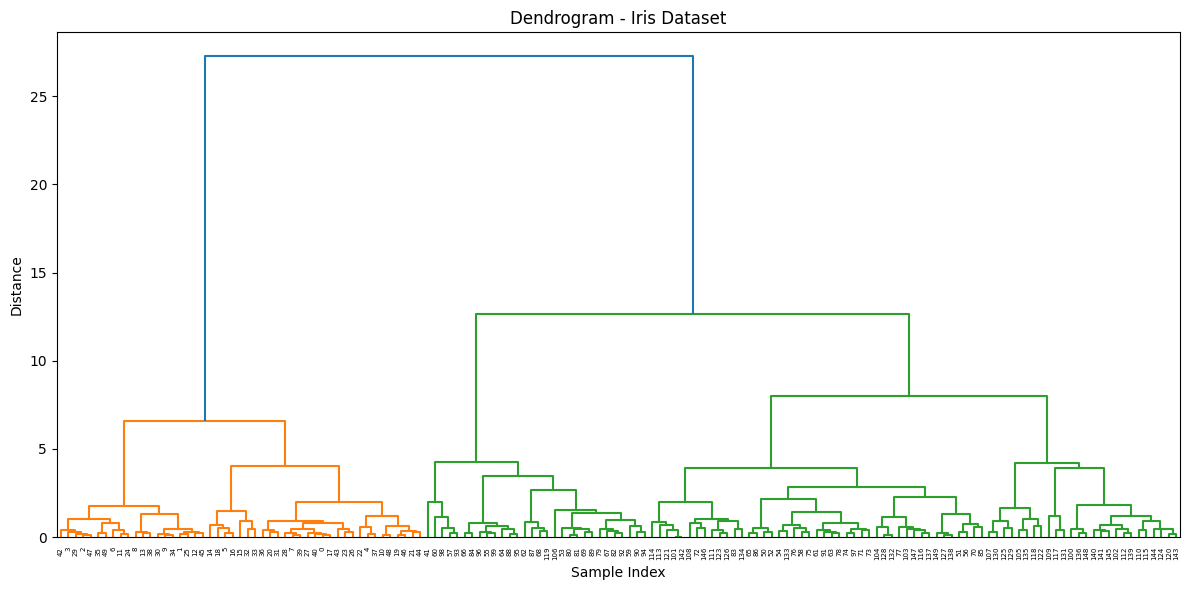

[6] Running DBSCAN...
    Best eps=1.4027, min_samples=3, score=0.5681
    Using eps=1.4027, min_samples=3
    Clusters found: 2
[7] Running OPTICS...
    Searching for optimal OPTICS parameters...


In [ ]:

# EXECUTION


iris_results = run_clustering_algorithms(iris_scaled, iris_labels, "Iris")
wine_results = run_clustering_algorithms(wine_scaled, wine_labels, "Wine")

print("\n" + "="*80)
print("PART 1 COMPLETE - ALL CLUSTERING ALGORITHMS EXECUTED")
print("="*80)
print("\nResults stored in:")
print("  - iris_results: Dictionary with clustering labels for Iris dataset")
print("  - wine_results: Dictionary with clustering labels for Wine dataset")
print("\nNext: Run Part 2 for evaluation metrics")



# CLUSTERING ASSIGNMENT - PART 2: EVALUATION METRICS
### Comprehensive evaluation and comparison of clustering algorithms

In [85]:
from sklearn.metrics import (
    rand_score, adjusted_rand_score,
    mutual_info_score, adjusted_mutual_info_score, normalized_mutual_info_score,
    silhouette_score, calinski_harabasz_score, davies_bouldin_score
)
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("CLUSTERING EVALUATION METRICS")
print("="*80)

CLUSTERING EVALUATION METRICS


In [86]:


# EVALUATION FUNCTIONS


def calculate_rand_metrics(true_labels, pred_labels):
    """Calculate Rand Index metrics"""
    try:
        # Handle noise points (-1) by treating them as a separate cluster
        valid_mask = pred_labels != -1
        if valid_mask.sum() == 0:
            return np.nan, np.nan

        rand = rand_score(true_labels[valid_mask], pred_labels[valid_mask])
        adj_rand = adjusted_rand_score(true_labels[valid_mask], pred_labels[valid_mask])
        return rand, adj_rand
    except:
        return np.nan, np.nan

def calculate_mutual_info_metrics(true_labels, pred_labels):
    """Calculate Mutual Information based metrics"""
    try:
        # Handle noise points (-1) by treating them as a separate cluster
        valid_mask = pred_labels != -1
        if valid_mask.sum() == 0:
            return np.nan, np.nan, np.nan

        mi = mutual_info_score(true_labels[valid_mask], pred_labels[valid_mask])
        ami = adjusted_mutual_info_score(true_labels[valid_mask], pred_labels[valid_mask])
        nmi = normalized_mutual_info_score(true_labels[valid_mask], pred_labels[valid_mask])
        return mi, ami, nmi
    except:
        return np.nan, np.nan, np.nan

def calculate_internal_metrics(data, pred_labels):
    """Calculate Internal Validation metrics"""
    try:
        # Filter out noise points
        valid_mask = pred_labels != -1
        if valid_mask.sum() == 0:
            return np.nan, np.nan, np.nan

        valid_data = data[valid_mask]
        valid_labels = pred_labels[valid_mask]

        # Check if we have at least 2 clusters
        n_clusters = len(np.unique(valid_labels))
        if n_clusters < 2:
            return np.nan, np.nan, np.nan

        silhouette = silhouette_score(valid_data, valid_labels)
        calinski = calinski_harabasz_score(valid_data, valid_labels)
        davies = davies_bouldin_score(valid_data, valid_labels)
        return silhouette, calinski, davies
    except:
        return np.nan, np.nan, np.nan

def calculate_sse_ssb(data, pred_labels):
    """Calculate SSE (Within-cluster) and SSB (Between-cluster) sum of squares"""
    try:
        # Filter out noise points
        valid_mask = pred_labels != -1
        if valid_mask.sum() == 0:
            return np.nan, np.nan, np.nan

        valid_data = data[valid_mask]
        valid_labels = pred_labels[valid_mask]

        # Overall mean
        overall_mean = np.mean(valid_data, axis=0)

        # SSE (Within-cluster sum of squares - Cohesion)
        sse = 0
        for cluster_id in np.unique(valid_labels):
            cluster_points = valid_data[valid_labels == cluster_id]
            cluster_mean = np.mean(cluster_points, axis=0)
            sse += np.sum((cluster_points - cluster_mean) ** 2)

        # SSB (Between-cluster sum of squares - Separation)
        ssb = 0
        for cluster_id in np.unique(valid_labels):
            cluster_points = valid_data[valid_labels == cluster_id]
            cluster_mean = np.mean(cluster_points, axis=0)
            n_points = len(cluster_points)
            ssb += n_points * np.sum((cluster_mean - overall_mean) ** 2)

        # SSE/SSB ratio (lower is better)
        ratio = sse / ssb if ssb != 0 else np.nan

        return sse, ssb, ratio
    except:
        return np.nan, np.nan, np.nan


In [87]:

#
# COMPREHENSIVE EVALUATION
#

def evaluate_clustering_results(data, true_labels, clustering_results, dataset_name):
    """Comprehensive evaluation of all clustering algorithms"""
    print(f"\n{'='*80}")
    print(f"EVALUATING {dataset_name.upper()} DATASET RESULTS")
    print(f"{'='*80}")

    # Storage for all metrics
    rand_metrics = []
    mi_metrics = []
    internal_metrics = []
    cohesion_separation = []

    algorithms = list(clustering_results.keys())

    for algo_name in algorithms:
        pred_labels = clustering_results[algo_name]

        print(f"\nEvaluating {algo_name}...")

        # 1. Rand Index metrics
        rand, adj_rand = calculate_rand_metrics(true_labels, pred_labels)
        rand_metrics.append({
            'Algorithm': algo_name,
            'Rand Score': rand,
            'Adjusted Rand Score': adj_rand
        })

        # 2. Mutual Information metrics
        mi, ami, nmi = calculate_mutual_info_metrics(true_labels, pred_labels)
        mi_metrics.append({
            'Algorithm': algo_name,
            'Mutual Info': mi,
            'Adjusted Mutual Info': ami,
            'Normalized Mutual Info': nmi
        })

        # 3. Internal validation metrics
        silhouette, calinski, davies = calculate_internal_metrics(data, pred_labels)
        internal_metrics.append({
            'Algorithm': algo_name,
            'Silhouette Coefficient': silhouette,
            'Calinski-Harabasz Index': calinski,
            'Davies-Bouldin Index': davies
        })

        # 4. Cohesion and Separation
        sse, ssb, ratio = calculate_sse_ssb(data, pred_labels)
        cohesion_separation.append({
            'Algorithm': algo_name,
            'SSE (Cohesion)': sse,
            'SSB (Separation)': ssb,
            'SSE/SSB Ratio': ratio
        })

    # Convert to DataFrames
    df_rand = pd.DataFrame(rand_metrics)
    df_mi = pd.DataFrame(mi_metrics)
    df_internal = pd.DataFrame(internal_metrics)
    df_cohesion = pd.DataFrame(cohesion_separation)

    return df_rand, df_mi, df_internal, df_cohesion

In [88]:

# DISPLAY RESULTS IN TABLES


def display_results(df_rand, df_mi, df_internal, df_cohesion, dataset_name):
    """Display all results in formatted tables"""

    print(f"\n{'='*80}")
    print(f"{dataset_name.upper()} DATASET - COMPREHENSIVE RESULTS")
    print(f"{'='*80}")

    # Table 1: Rand Index Metrics
    print(f"\n[Table 1] Rand Index Metrics - {dataset_name}")
    print(tabulate(df_rand, headers='keys', tablefmt='grid', showindex=False, floatfmt='.4f'))

    # Table 2: Mutual Information Metrics
    print(f"\n[Table 2] Mutual Information Metrics - {dataset_name}")
    print(tabulate(df_mi, headers='keys', tablefmt='grid', showindex=False, floatfmt='.4f'))

    # Table 3: Internal Validation Metrics
    print(f"\n[Table 3] Internal Validation Metrics - {dataset_name}")
    print(tabulate(df_internal, headers='keys', tablefmt='grid', showindex=False, floatfmt='.4f'))

    # Table 4: Cohesion and Separation Metrics
    print(f"\n[Table 4] Cohesion and Separation Metrics - {dataset_name}")
    print(tabulate(df_cohesion, headers='keys', tablefmt='grid', showindex=False, floatfmt='.4f'))

In [89]:

# PERFORMANCE COMPARISON BY CATEGORY


def compare_by_category(iris_results_dict, wine_results_dict):
    """Compare algorithms by their category"""

    print(f"\n{'='*80}")
    print("PERFORMANCE COMPARISON BY ALGORITHM CATEGORY")
    print(f"{'='*80}")

    categories = {
        'Partition-based': ['K-Means', 'K-Means++', 'Bisecting K-Means', 'K-Medoids'],
        'Hierarchical': ['Hierarchical'],
        'Density-based': ['DBSCAN', 'OPTICS']
    }

    for dataset_name, results_dict in [('Iris', iris_results_dict), ('Wine', wine_results_dict)]:
        print(f"\n{'='*80}")
        print(f"{dataset_name.upper()} DATASET - CATEGORY-WISE BEST PERFORMERS")
        print(f"{'='*80}")

        df_rand, df_mi, df_internal, df_cohesion = results_dict

        for category, algorithms in categories.items():
            print(f"\n[{category} Algorithms]")

            # Filter for algorithms in this category
            category_rand = df_rand[df_rand['Algorithm'].isin(algorithms)]
            category_internal = df_internal[df_internal['Algorithm'].isin(algorithms)]

            if len(category_rand) == 0:
                print("  No results available")
                continue

            # Find best performer based on Adjusted Rand Score
            best_idx = category_rand['Adjusted Rand Score'].idxmax()
            if pd.notna(category_rand.loc[best_idx, 'Adjusted Rand Score']):
                best_algo = category_rand.loc[best_idx, 'Algorithm']
                best_score = category_rand.loc[best_idx, 'Adjusted Rand Score']
                print(f"  Best Algorithm: {best_algo}")
                print(f"  Adjusted Rand Score: {best_score:.4f}")

                # Show its internal metrics too
                internal_row = category_internal[category_internal['Algorithm'] == best_algo].iloc[0]
                print(f"  Silhouette Score: {internal_row['Silhouette Coefficient']:.4f}")
                print(f"  Calinski-Harabasz: {internal_row['Calinski-Harabasz Index']:.4f}")
                print(f"  Davies-Bouldin: {internal_row['Davies-Bouldin Index']:.4f}")
            else:
                print("  No valid scores for comparison")


In [90]:

# ACCURACY ANALYSIS

def analyze_accuracy(df_rand, dataset_name):
    """Analyze if algorithms meet >=80% accuracy threshold"""
    print(f"\n{'='*80}")
    print(f"ACCURACY ANALYSIS - {dataset_name.upper()} DATASET")
    print(f"{'='*80}")
    print("\nAdjusted Rand Score Analysis:")
    print("-" * 50)

    accuracy_data = []
    for _, row in df_rand.iterrows():
        algo = row['Algorithm']
        score = row['Adjusted Rand Score']

        if pd.notna(score):
            percentage = score * 100

            accuracy_data.append({
                'Algorithm': algo,
                'Adjusted Rand Score': score,
                'Percentage': f"{percentage:.2f}%",

            })
        else:
            accuracy_data.append({
                'Algorithm': algo,
                'Adjusted Rand Score': 'N/A',
                'Percentage': 'N/A',

            })

    df_accuracy = pd.DataFrame(accuracy_data)
    print(tabulate(df_accuracy, headers='keys', tablefmt='grid', showindex=False))




In [93]:
#
# VISUALIZATION FUNCTIONS
#

def plot_clustering_comparison(data, true_labels, clustering_results, dataset_name):
    """
    Visualize all clustering results using PCA for dimensionality reduction
    """
    from sklearn.decomposition import PCA

    # Reduce to 2D for visualization
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)

    algorithms = list(clustering_results.keys())
    n_algos = len(algorithms)

    # Create subplot grid
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(f'{dataset_name} Dataset - Clustering Comparison (PCA Projection)',
                 fontsize=16, fontweight='bold')

    # Flatten axes for easy iteration
    axes = axes.flatten()

    # Plot true labels first
    scatter = axes[0].scatter(data_2d[:, 0], data_2d[:, 1],
                             c=true_labels, cmap='viridis',
                             s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
    axes[0].set_title('True Labels', fontweight='bold', fontsize=12)
    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    plt.colorbar(scatter, ax=axes[0])

    # Plot each algorithm
    for idx, algo_name in enumerate(algorithms, 1):
        pred_labels = clustering_results[algo_name]

        # Handle noise points for density-based methods
        colors = pred_labels.copy()
        if -1 in colors:
            # Map -1 (noise) to a distinct color
            colors = colors + 1  # Shift to make -1 become 0
            cmap = plt.cm.tab10
        else:
            cmap = 'viridis'

        scatter = axes[idx].scatter(data_2d[:, 0], data_2d[:, 1],
                                   c=colors, cmap=cmap,
                                   s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
        axes[idx].set_title(algo_name, fontweight='bold', fontsize=12)
        axes[idx].set_xlabel(f'PC1')
        axes[idx].set_ylabel(f'PC2')

        # Add cluster count
        n_clusters = len(set(pred_labels)) - (1 if -1 in pred_labels else 0)
        noise_count = list(pred_labels).count(-1)
        axes[idx].text(0.02, 0.98, f'Clusters: {n_clusters}\nNoise: {noise_count}',
                      transform=axes[idx].transAxes,
                      verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                      fontsize=9)

    plt.tight_layout()
    plt.show()


def plot_metric_comparison(iris_dfs, wine_dfs):
    """
    Create bar charts comparing all algorithms across key metrics
    """
    iris_rand, iris_mi, iris_internal, iris_cohesion = iris_dfs
    wine_rand, wine_mi, wine_internal, wine_cohesion = wine_dfs

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Clustering Performance Metrics Comparison', fontsize=16, fontweight='bold')

    algorithms = iris_rand['Algorithm'].values

    # Iris - Adjusted Rand Score
    axes[0, 0].barh(algorithms, iris_rand['Adjusted Rand Score'], color='skyblue', edgecolor='black')
    axes[0, 0].set_xlabel('Adjusted Rand Score')
    axes[0, 0].set_title('Iris: External Validation (ARI)', fontweight='bold')
    axes[0, 0].set_xlim(0, 1)
    axes[0, 0].grid(axis='x', alpha=0.3)

    # Iris - Silhouette Score
    axes[0, 1].barh(algorithms, iris_internal['Silhouette Coefficient'], color='lightgreen', edgecolor='black')
    axes[0, 1].set_xlabel('Silhouette Coefficient')
    axes[0, 1].set_title('Iris: Cluster Cohesion', fontweight='bold')
    axes[0, 1].set_xlim(0, 1)
    axes[0, 1].grid(axis='x', alpha=0.3)

    # Iris - Davies-Bouldin
    axes[0, 2].barh(algorithms, iris_internal['Davies-Bouldin Index'], color='lightcoral', edgecolor='black')
    axes[0, 2].set_xlabel('Davies-Bouldin Index')
    axes[0, 2].set_title('Iris: Cluster Separation (lower=better)', fontweight='bold')
    axes[0, 2].grid(axis='x', alpha=0.3)

    # Wine - Adjusted Rand Score
    axes[1, 0].barh(algorithms, wine_rand['Adjusted Rand Score'], color='skyblue', edgecolor='black')
    axes[1, 0].set_xlabel('Adjusted Rand Score')
    axes[1, 0].set_title('Wine: External Validation (ARI)', fontweight='bold')
    axes[1, 0].set_xlim(0, 1)
    axes[1, 0].grid(axis='x', alpha=0.3)

    # Wine - Silhouette Score
    axes[1, 1].barh(algorithms, wine_internal['Silhouette Coefficient'], color='lightgreen', edgecolor='black')
    axes[1, 1].set_xlabel('Silhouette Coefficient')
    axes[1, 1].set_title('Wine: Cluster Cohesion', fontweight='bold')
    axes[1, 1].set_xlim(0, 0.5)
    axes[1, 1].grid(axis='x', alpha=0.3)

    # Wine - Davies-Bouldin
    axes[1, 2].barh(algorithms, wine_internal['Davies-Bouldin Index'], color='lightcoral', edgecolor='black')
    axes[1, 2].set_xlabel('Davies-Bouldin Index')
    axes[1, 2].set_title('Wine: Cluster Separation (lower=better)', fontweight='bold')
    axes[1, 2].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()





[STARTING EVALUATION]
This will evaluate all clustering results from Part 1...

EVALUATING IRIS DATASET RESULTS

Evaluating K-Means...

Evaluating K-Means++...

Evaluating Bisecting K-Means...

Evaluating K-Medoids...

Evaluating Hierarchical...

Evaluating DBSCAN...

Evaluating OPTICS...

EVALUATING WINE DATASET RESULTS

Evaluating K-Means...

Evaluating K-Means++...

Evaluating Bisecting K-Means...

Evaluating K-Medoids...

Evaluating Hierarchical...

Evaluating DBSCAN...

Evaluating OPTICS...

IRIS DATASET - COMPREHENSIVE RESULTS

[Table 1] Rand Index Metrics - Iris
+-------------------+--------------+-----------------------+
| Algorithm         |   Rand Score |   Adjusted Rand Score |
+===================+==============+=======================+
| K-Means           |       0.8278 |                0.6101 |
+-------------------+--------------+-----------------------+
| K-Means++         |       0.8322 |                0.6201 |
+-------------------+--------------+---------------------

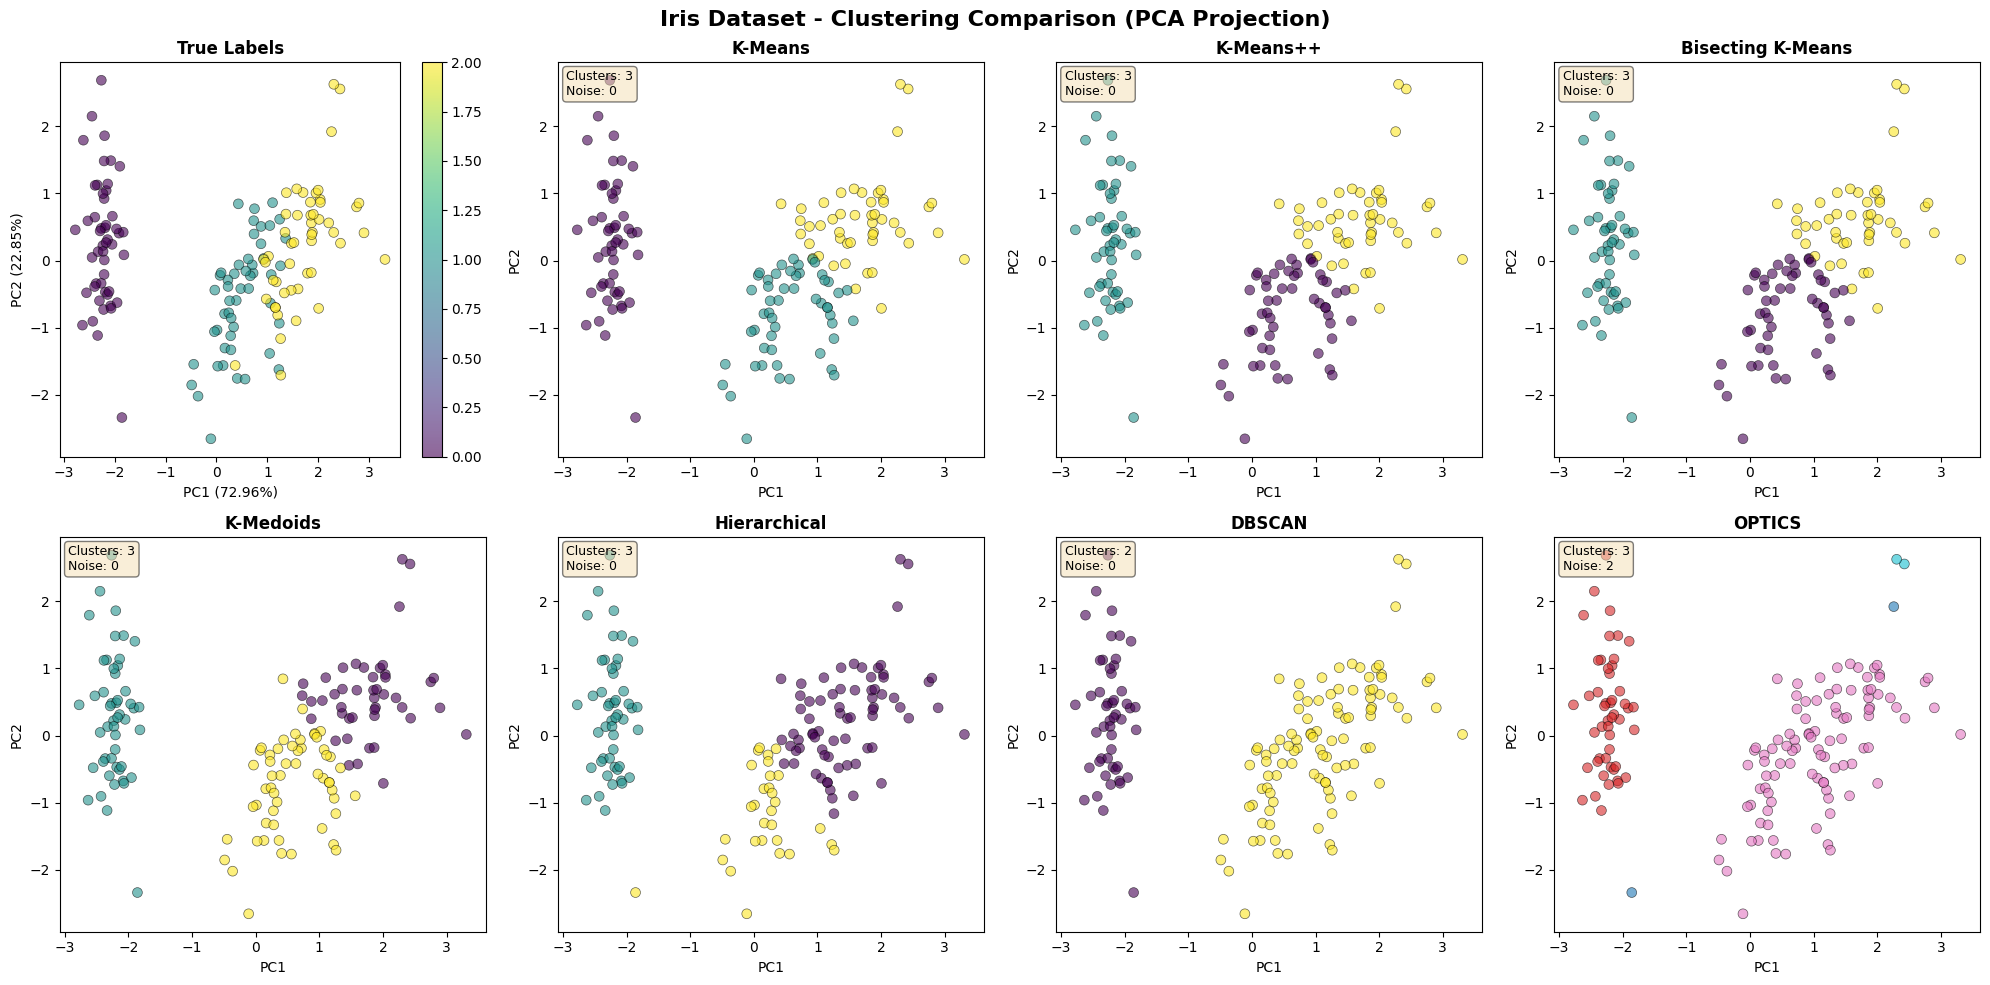

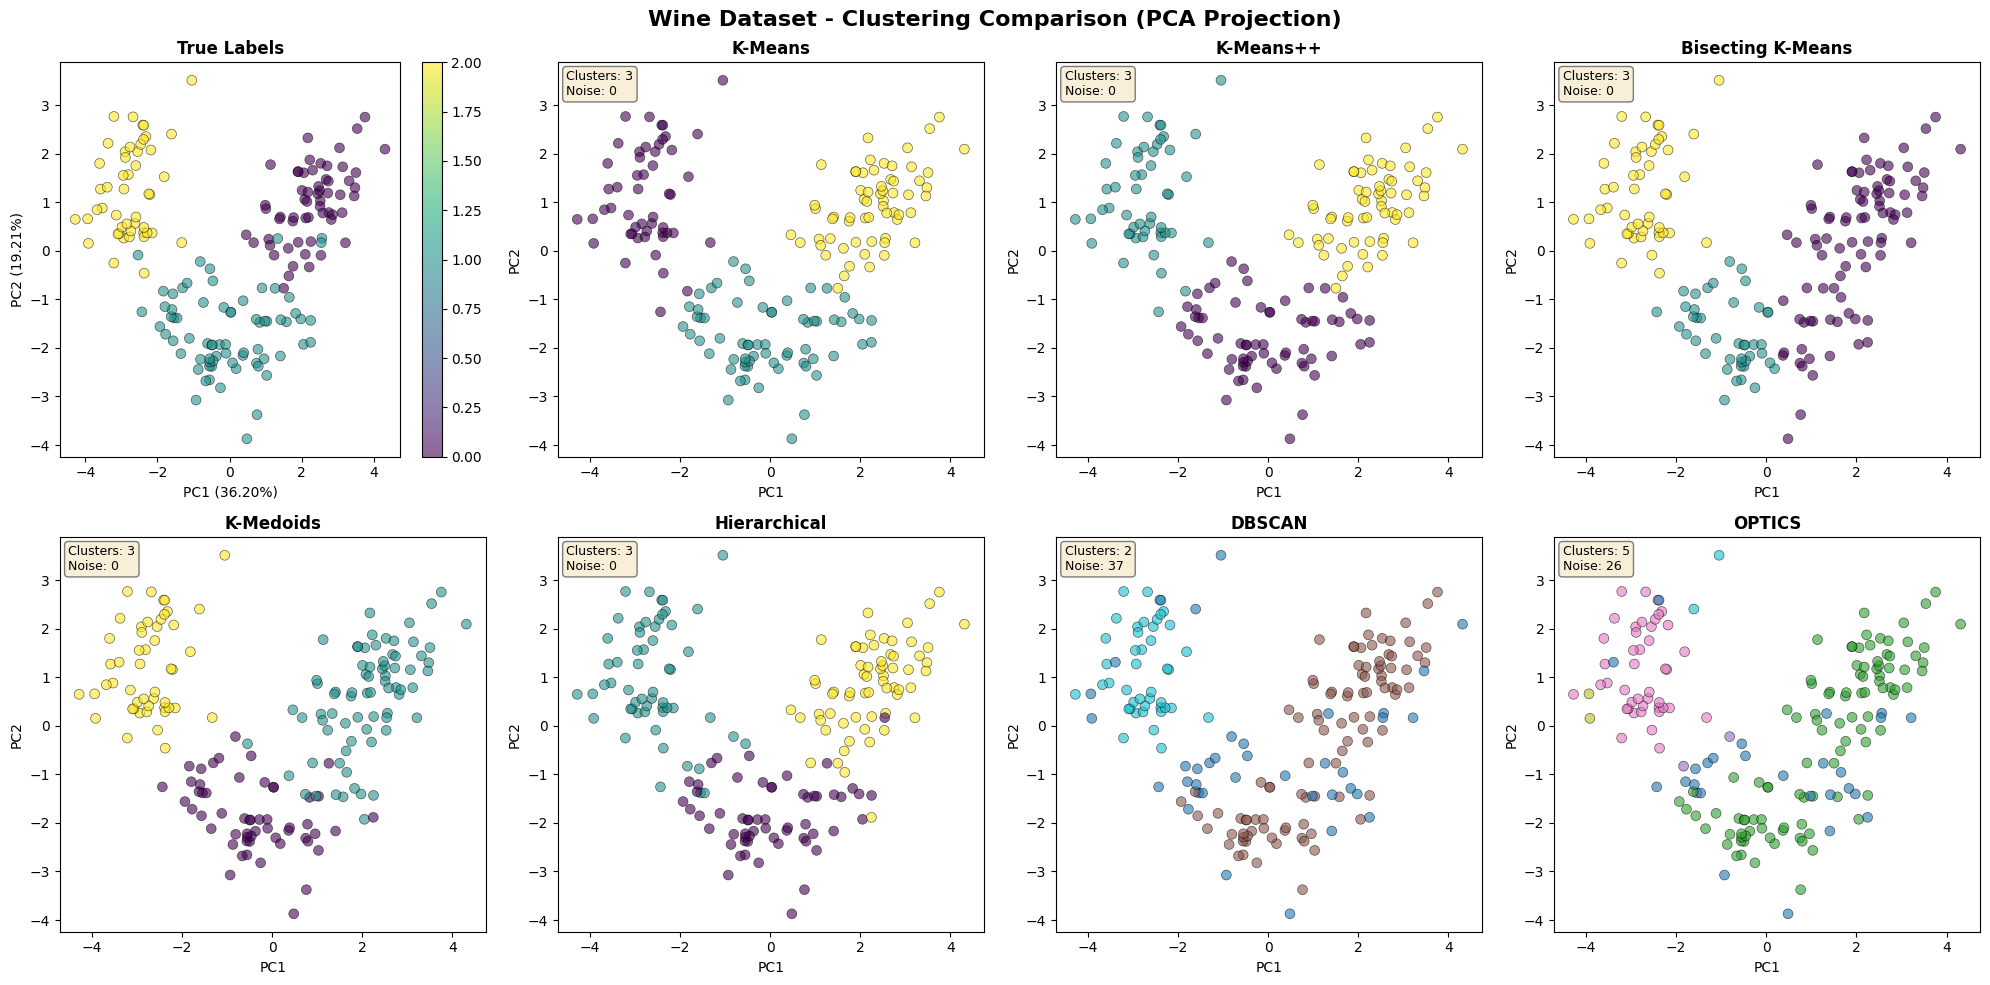

[2] Generating metric comparison charts...


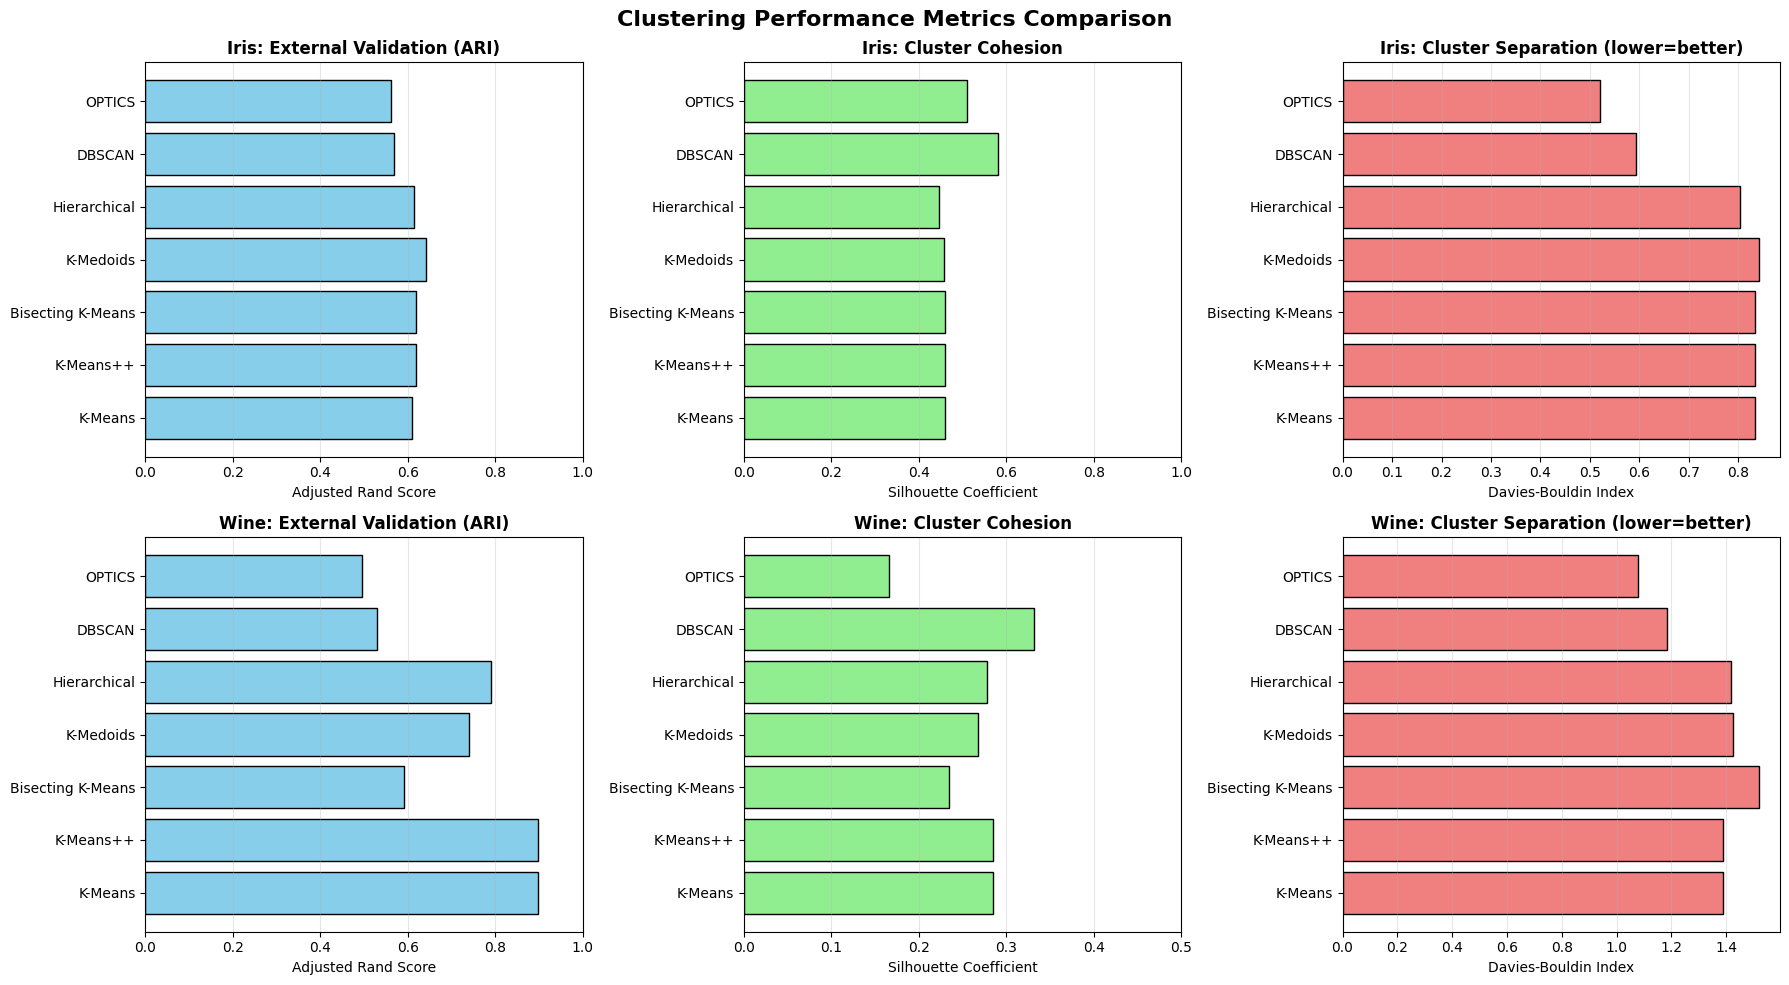



All results are stored in DataFrames:
  Iris: iris_rand, iris_mi, iris_internal, iris_cohesion
  Wine: wine_rand, wine_mi, wine_internal, wine_cohesion


In [95]:
# ============================================================================
# EXECUTION WITH VISUALIZATIONS
# ============================================================================

print("\n[STARTING EVALUATION]")
print("This will evaluate all clustering results from Part 1...")

# Evaluate Iris dataset
iris_rand, iris_mi, iris_internal, iris_cohesion = evaluate_clustering_results(
    iris_scaled, iris_labels, iris_results, "Iris"
)

# Evaluate Wine dataset
wine_rand, wine_mi, wine_internal, wine_cohesion = evaluate_clustering_results(
    wine_scaled, wine_labels, wine_results, "Wine"
)

# Display all results
display_results(iris_rand, iris_mi, iris_internal, iris_cohesion, "Iris")
display_results(wine_rand, wine_mi, wine_internal, wine_cohesion, "Wine")

# Compare by category
iris_results_dict = (iris_rand, iris_mi, iris_internal, iris_cohesion)
wine_results_dict = (wine_rand, wine_mi, wine_internal, wine_cohesion)
compare_by_category(iris_results_dict, wine_results_dict)

# Analyze accuracy
analyze_accuracy(iris_rand, "Iris")
analyze_accuracy(wine_rand, "Wine")

print("\n" + "="*80)
print("GENERATING COMPREHENSIVE VISUALIZATIONS")
print("="*80)

# 1. Clustering comparison plots
print("\n[1] Generating clustering comparison visualizations...")
plot_clustering_comparison(iris_scaled, iris_labels, iris_results, "Iris")
plot_clustering_comparison(wine_scaled, wine_labels, wine_results, "Wine")

# 2. Metric comparison bar charts
print("[2] Generating metric comparison charts...")
plot_metric_comparison(iris_results_dict, wine_results_dict)

print("\n" + "="*80)
print("="*80)
print("\nAll results are stored in DataFrames:")
print("  Iris: iris_rand, iris_mi, iris_internal, iris_cohesion")
print("  Wine: wine_rand, wine_mi, wine_internal, wine_cohesion")
